# Facilities KPI Scorecard
This notebook serves as a repository of public-facing KPIs for the Department of General Services' Facilities Division. The purpose of this notebook is to make available, in a single public place, the entire pipeline for calculating the division's three KPIs that are based in Archibus. Those KPIs are:

1. % of Corrective Maintenance Work Requests Completed On Time
2. % of Preventive Maintenance Work Requests Completed On Time
3. Preventive Maintenance to Corrective Maintenance Ratio

Part of the intention of this notebook is to build _transparency_ and _reproducibility_ by capturing the entire end-to-end process used to calculate these metrics in one place.

The actuals for previous year for KPIs 1 and 2 shown here are slightly higher than those reported in the Clear Impact budget book. That is because a coding error caused us to undercount the data. That error has now been fixed and the numbers shown here are more accurate. 

__Questions__: This notebook was last modified by James Trimarco, DGS Research Analyst, on May 11 2021. Questions and concerns about this work can be directed to james.trimarco@baltimorecity.gov.

__Note__: After the implementation of our Archibus dashboards and their incorporation into management workflows, DGS became aware of the need to further improve the third metric (Preventive Maintenance to Corrective Maintenance Ratio). Because this metric is still under construction, it is not shown here. 

## Setup

### Import packages
This step imports a group of common analysis packages, as well as a few custom functions. 

In [1]:
# workhorse modules
import pandas as pd
from datetime import timedelta, datetime
import re
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

# local utility functions
from utils.general_utils import (
    add_fiscal_year,
    compute_is_on_time,
    set_pd_params,
    tidy_up_df,
    cast_dtypes,
    compute_pm_cm,
    compute_pm_cm_by_month,
    compute_kpi_table,
    compute_kpi_table_by_month,
)
from utils.sql_utils import mssql_engine, get_data_from_archibus
from utils.vis_utils import set_plot_params, pointplot_with_barplot
from utils.anonymization import split_names, replace_names

### Set Pandas options
This makes the Pandas library print all the rows and columns to the output, instead of truncating output. 

In [2]:
set_pd_params()
set_plot_params()
pd.options.mode.chained_assignment = None  # default='warn'

### Import the work request data from Archibus database
The command below pulls every row from Archibus's `dash_benchmarks` table, which enhances the raw operational data by adding several important columns including:

- __primary_type__: Consolidates the `problem_type` down from more than 100 raw types into just 30 consolidated and benchmarked problem types.
- __days_to_completion__: Number of days between the date a job was requested and the date it was marked completed.
- __benchmark__: Number of days that can pass between request and completion before a job is marked late. 

The resulting data contains the entire work request history. No filtering by date has been applied yet. 

Readers interested in the steps used to create `dash_benchmarks` from the raw operational data can find [the SQL query used to do this here](https://raw.githubusercontent.com/department-of-general-services/fmd_archibus_dashboard/master/create_views_facilities_dashboard.sql).


In [3]:
kpis_raw = get_data_from_archibus(mssql_engine())
print(f"The work orders dataframe has {kpis_raw.shape[0]:,} rows.")

The work orders dataframe has 107,901 rows.


Here's a sample of a few rows, showing some of the key columns.

In [4]:
kpis_raw.sample(3, random_state=445)[
    [
        "wr_id",
        "status",
        "primary_type",
        "problem_type",
        "status",
        "date_requested",
        "date_completed",
        "days_to_completion",
        "date_closed",
        "benchmark",
    ]
]

,wr_id,status,primary_type,problem_type,status,date_requested,date_completed,days_to_completion,date_closed,benchmark
21452,12989,Clo,LANDSCAPING,LAWN,Clo,2014-07-11,2014-07-21,10.0,2014-07-24 00:00:00.000,14.0
74973,97313,Clo,DELIVERY,_DELIVERY,Clo,2017-12-12,2017-12-13,1.0,2018-01-11 11:48:56.760,7.0
31137,27533,Clo,SERVICE,SERV/CUSTODIAL,Clo,2015-03-19,2015-03-19,0.0,2015-03-20 00:00:00.000,14.0


## Data cleaning
For the purposes of this project, DGS is keeping the data-cleaning stage simple. We're not attempting to remove duplicates or outliers, both of which involve relatively complex operations. 

### Basic cleaning
- removes white spaces in strings to facilitate matching 
- drops rows with a problem type of "TEST(DO NOT USE)"
- renames a few columns for clarity

In [5]:
wr_tidy = tidy_up_df(kpis_raw)
wr_tidy["year"] = wr_tidy["calendar_month_request"].str[:4].astype(int)
wr_tidy["month"] = wr_tidy["calendar_month_request"].str[-2:].astype(int)
wr_tidy["month_start"] = pd.to_datetime(wr_tidy[["year", "month"]].assign(DAY=1))


print(f"The tidied work orders dataframe has {len(wr_tidy):,} rows.")
print(f"By tidying the data, we have removed {len(kpis_raw) - len(wr_tidy):,} rows.")

The tidied work orders dataframe has 107,774 rows.
By tidying the data, we have removed 127 rows.


### Drop canceled and rejected work orders
The data comes to us with many canceled work orders. Those shouldn't count against our KPIs as not having been completed on time. So we drop them here. 

In [6]:
# drop rows that were canceled
cond_valid = ~wr_tidy["status"].isin(["Can", "Rej", "R"])

wr_valid = wr_tidy[cond_valid]

print(
    f"By dropping canceled and rejected work orders, we have removed {len(wr_tidy) - len(wr_valid):,} rows."
)

By dropping canceled and rejected work orders, we have removed 4,011 rows.


### Assign fiscal year
The Facilities Management Division has made the decision to compute KPIs based on the fiscal year when the job was _closed_, not the fiscal year when it was _requested_. There are pros and cons to either way, and our dashboards will show both views when they are complete. However, here are some of the advantages of assigning the fiscal year based on the date of closure:

- __Historical numbers are stable__. Once a KPI is reported for a fiscal year, the number will not change (if we computed % on time based on the date of request, the results for previous years would continue to change significantly as old work requests get closed out). 
- __Accountability assigned to current year__. If we computed % on time based on the date of request, then old years would make the division look slow in the past. Assigning by the date of closure keeps accountability with the act of completion. 

In [7]:
wr_fy = wr_valid.copy()
cond_fy = wr_fy["fy_request"].isin(range(2016, 2022))
wr_fy = wr_fy[cond_fy]

In [11]:
def compute_is_on_time(row):
    row["is_on_time"] = row["days_to_completion"] <= row["benchmark"]
    return row


wr_fy = wr_fy.dropna(subset=["days_to_completion", "benchmark"]).apply(
    compute_is_on_time, axis=1
)

In [12]:
wr_fy['PM_type'].value_counts()

BLDG INSPECTION     1403
GENERATOR TEST      1010
ELEVATOR TEST        973
HVAC INSPECTION      839
BASEMENT INSPECT     689
FUEL TANK TEST       517
HEATING LEVELS       414
HEAT CHECK TEST      180
UTILITY ROOMS        113
FLOOR BUFFING         62
HVAC FILTER CHAN      21
KITCHEN PM            15
EXTERMINATION         10
Name: PM_type, dtype: int64

In [13]:
# add 'fiscal_year' column based on date_closed
wr_fy = add_fiscal_year(wr_valid, assign_fy_on="closure")

wr_fy[["primary_type", "date_requested", "date_closed", "fiscal_year"]].sample(
    3, random_state=446
)

,primary_type,date_requested,date_closed,fiscal_year
11195,OTHER-INTERNAL,2013-12-09,2013-12-09 00:00:00.000,2014
18526,ELECTRICAL,2014-05-09,2014-05-16 00:00:00.000,2014
63014,OVERHDDOOR,2017-02-28,2020-12-22 08:25:28.970,2021


## Data preparation

After assigning the fiscal year, we can drop work requests from FY16 and older. This allows us to focus on recent history. 

In [8]:
cond_fy = wr_fy["fiscal_year"].isin(range(2017, 2022))
wr_valid = wr_fy[cond_fy]

print(
    f"Filtering to remove data requested before FY17 leaves us with {len(wr_valid):,} rows.",
    f"\nWe dropped {100 * round((len(wr_fy) - len(wr_valid))/len(wr_fy), 2):}% of the data at this stage.",
)

Filtering to remove data requested before FY17 leaves us with 57,207 rows. 
We dropped 45.0% of the data at this stage.


### Drop rows still in process
First we need to drop all rows that haven't been marked completed yet, since we do not know whether those will be on time. 





In [9]:
wr_main = wr_valid.dropna(subset=["date_completed"])

print(
    f"Filtering to remove jobs with no data for `date_completed` drops {len(wr_valid) - len(wr_main):,} rows.",
    f"\nWe dropped {100 * round((len(wr_valid) - len(wr_main))/len(wr_valid), 2):}% of the data at this stage.",
)

Filtering to remove jobs with no data for `date_completed` drops 348 rows. 
We dropped 1.0% of the data at this stage.


## KPI 1: % PMs Completed On Time 
The goal here is to filter the data to preventive maintenance jobs only, and then show how many are completed on or before the benchmark (21 days).

### Filter to  preventive maintenance work requests only
For this metric, we want to select every single PM that Facilities Management does. We can do this by selecting 5 values for the original, non-consolidated problem type. 

In [10]:
wr_pm = wr_main.copy()

# this defines which problem types are considered PMs
pm_list = [
    "BUILDING INTERIOR INSPECTION",
    "BUILDING PM",
    "HVAC|PM",
    "INSPECTION",
    "PREVENTIVE MAINT",
]

# filter data to PM types only
cond_pm = wr_pm["problem_type"].isin(pm_list)

# apply filter conditions
wr_pm = wr_pm[cond_pm]

# the benchmark for all PMs is 21 days
wr_pm["benchmark"] = 21

print(f"The filtered PMs dataframe has {wr_pm.shape[0]:,} rows.")

The filtered PMs dataframe has 7,094 rows.


#### Compute whether each work request was completed on time

Then the function `compute_is_on_time` compares the column `days_to_completion` to the benchmark and writes down whether the work request was completed on time. 

In [11]:
### Filter to valid PM only, and for relevant fiscal years only
After noticing that many PMs have the status "Can" — meaning they were canceled — we fil

In [14]:
# add "is_on_time" column with performance data
pms_on_time = wr_pm.apply(compute_is_on_time, axis=1)

In [37]:
#### Inspect the relevant rows
A look at the data shows that PMs that took longer than 21 days to complete now contain a value of False in the colum `is_on_time`. PMs that were completed in 21 days or fewer contain a True. 

primary_type        PM_type         
PREVENTIVE_HVAC     HVAC INSPECTION      839
                    HEATING LEVELS       414
                    HEAT CHECK TEST      180
                    HVAC FILTER CHAN      21
PREVENTIVE_GENERAL  BLDG INSPECTION     1403
                    GENERATOR TEST      1010
                    ELEVATOR TEST        973
                    BASEMENT INSPECT     689
                    FUEL TANK TEST       517
                    UTILITY ROOMS        113
                    FLOOR BUFFING         62
                    KITCHEN PM            15
                    EXTERMINATION         10
Name: wr_id, dtype: int64

In [12]:
pms_on_time[["problem_type", "PM_type", "date_requested", "date_completed", "days_to_completion", "benchmark", "is_on_time"]].sample(
    3, random_state=446
)

,problem_type,PM_type,date_requested,date_completed,days_to_completion,benchmark,is_on_time
54995,PREVENTIVE MAINT,HVAC INSPECTION,2016-09-01,2016-11-02,62.0,21,False
89777,PREVENTIVE MAINT,BLDG INSPECTION,2019-01-08,2019-01-28,20.0,21,True
80594,BUILDING INTERIOR INSPECTION,None,2018-04-26,2018-04-26,0.0,21,True


#### Group by fiscal year and get % on time
Now that we've stored all this information, we can group by the fiscal year to get each year's KPI, together with a count of how many PMs were closed in that fiscal year.

In [13]:
pm_compliance = compute_kpi_table(
    pms_on_time, "percent_PMs_on_time", "total_PMs", grouping_var="fiscal_year"
)
pm_compliance

,percent_PMs_on_time,total_PMs
fiscal_year,,
2017,54.77,1289
2018,80.50,1195
2019,92.41,764
2020,50.31,1928
2021,30.40,1918


### Visualization: % Preventive Work Requests on Time by Fiscal Year Closed
Fiscal years 2020 and 2021 were characterized by the closing out of many backlog work requests, which lowered the percentage of work requests that are on time. 

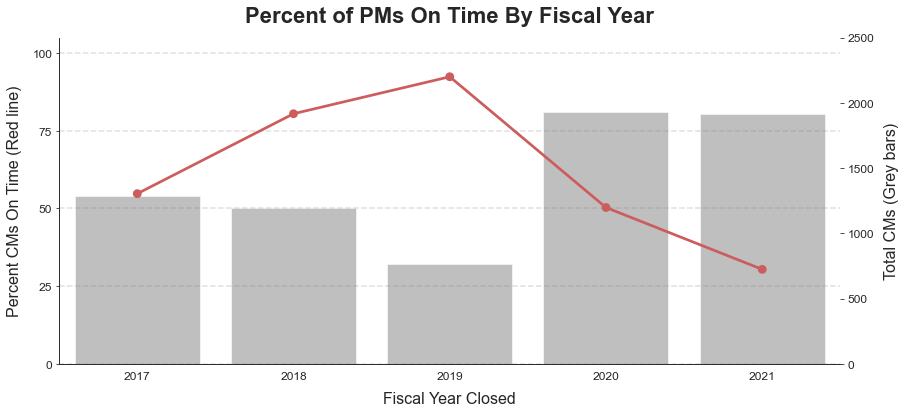

In [14]:
pointplot_with_barplot(
    pm_compliance,
    x="fiscal_year",
    point_y="percent_PMs_on_time",
    bar_y="total_PMs",
    ymax_bar=2_500,
    xlabel="Fiscal Year Closed",
    ylabel_point="Percent CMs On Time (Red line)",
    ylabel_bar="Total CMs (Grey bars)",
    title="Percent of PMs On Time By Fiscal Year",
)

## KPI 2: Percent of Corrective Work Requests Completed On-Time
Here are the key facts needed to understand the agency's new method for computing this KPI:

- Only corrective problem types are considered, so all preventive work requests are dropped.
- The work orders are first assigned a "primary" problem type, which reduces the number of problem types from about 110 to 30
- Each of these primary problem types has an on-time benchmark 
- The work order is determined to be on-time based on comparing its time to completion to its benchmark

### Filter to get CMs only

In [15]:
wr_cm = wr_main.copy()

pm_list = [
    "BUILDING INTERIOR INSPECTION",
    "BUILDING PM",
    "HVAC|PM",
    "INSPECTION",
    "PREVENTIVE MAINT",
]

cond_cm = ~wr_cm["problem_type"].isin(pm_list)
wr_cm = wr_cm[cond_cm]

print(
    f"Selecting only corrective maintenance jobs leaves us with {len(wr_cm):,} rows."
)

Selecting only corrective maintenance jobs leaves us with 49,765 rows.


In [16]:
wr_cm.sample(6, random_state=444)[
    ["problem_type", "primary_type", "benchmark", "days_to_completion"]
]

,problem_type,primary_type,benchmark,days_to_completion
58007,SERV/CUSTODIAL,SERVICE,14.0,0.0
90508,HVAC|REPAIR,HVAC,30.0,8.0
98141,HVAC,HVAC,30.0,29.0
94034,HVAC,HVAC,30.0,16.0
93184,BATHROOM_FIXT,BATHROOM,14.0,72.0
90776,PAINT,PAINTING,21.0,3.0


### Compute whether requests are on time

In [17]:
# assign a benchmark of 30 days for small number of WRs without benchmarks
wr_cm["benchmark"] = wr_cm["benchmark"].fillna(30)
# compute whether jobs are on time
cms_on_time = wr_cm.apply(compute_is_on_time, axis=1)

### Group by fiscal year to get % on time per fiscal year

In [18]:
cm_compliance = compute_kpi_table(
    cms_on_time, "percent_CMs_on_time", "total_CMs", grouping_var="fiscal_year"
)
cm_compliance

,percent_CMs_on_time,total_CMs
fiscal_year,,
2017,72.55,13962
2018,71.85,10020
2019,67.43,5661
2020,54.66,9040
2021,40.40,11082


### Visualization: % Corrective Work Requests on Time by Fiscal Year Closed
Efforts to close out the backlog bring the FY21 number down a bit. Facilities Maintenance expects FY22 figures to improve as 

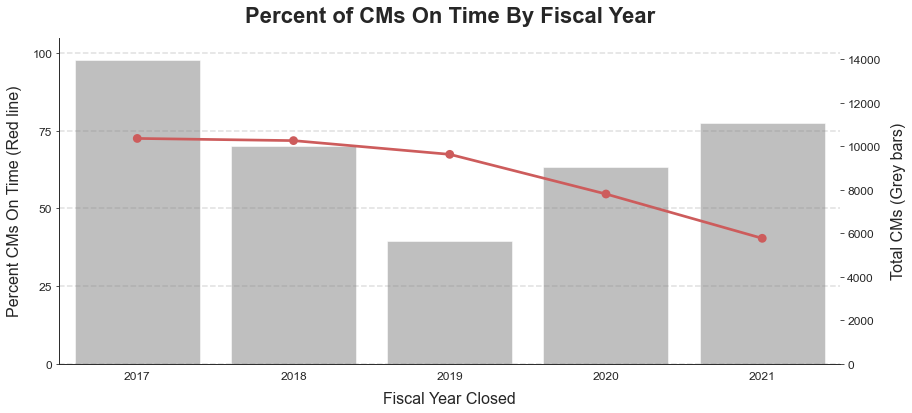

In [19]:
pointplot_with_barplot(
    cm_compliance,
    x="fiscal_year",
    point_y="percent_CMs_on_time",
    bar_y="total_CMs",
    ymax_bar=15_000,
    xlabel="Fiscal Year Closed",
    ylabel_point="Percent CMs On Time (Red line)",
    ylabel_bar="Total CMs (Grey bars)",
    title="Percent of CMs On Time By Fiscal Year",
)

## KPI 3: PM:CM Ratio

This KPI remains under contstruction as DGS works to choose categories of related categories of preventive and corrective maintenance that extend beyond just HVAC. Therefore, we've commented out the code for this KPI. 

In [20]:
# CM_list = [
#     "BOILER",
#     "CHILLERS",
#     "COOLING TOWERS",
#     "HVAC",
#     "HVAC INFRASTRUCTURE",
#     "HVAC|REPAIR",
# ]

# PM_list = [
#     "HVAC|PM",
#     "PREVENTIVE MAINT",
# ]

### Filter to HVAC rows only

In [21]:
# cond_cm = wr_main["problem_type"].isin(CM_list)
# cond_pm = wr_main["problem_type"].isin(PM_list)

# wr_HVAC = wr_main[cond_cm | cond_pm]
# wr_HVAC["is_pm"] = wr_HVAC["problem_type"].isin(PM_list)

# print(
#     f"Filtering to HVAC request only takes us from {len(wr_fy):,} rows to {len(wr_HVAC):,} rows."
# )

Filtering to HVAC request only takes us from 70,948 rows to 12,980 rows.


In [28]:
wr_HVAC['PM_type'].value_counts()

HVAC INSPECTION     839
HEATING LEVELS      414
HEAT CHECK TEST     180
HVAC FILTER CHAN     21
Name: PM_type, dtype: int64

### Compute all PM/CM stats by fiscal year
First we deploy a custom function that counts the PMs and CMs in each fiscal year and then calculates the PM:CM ratio.

In [22]:
# pm_cm_results = compute_pm_cm(wr_HVAC, PM_list)

In [23]:
# pm_cm_results

,fiscal_year,pm_cm_ratio,count_cm,count_pm,count_hvac
0,2016,1.301406,1921,25,1946
1,2017,11.901441,2151,256,2407
2,2018,17.055215,2445,417,2862
3,2019,18.277512,2090,382,2472
4,2020,25.510768,1811,462,2273
5,2021,9.913793,928,92,1020


### Plot PM:CM ratio by fiscal year

In [24]:
# pointplot_with_barplot(
#     pm_cm_results,
#     x="fiscal_year",
#     point_y="pm_cm_ratio",
#     bar_y="count_hvac",
#     ymax_bar=5_000,
#     ylabel_point="PM:CM Ratio",
#     ylabel_bar="Total HVAC Work Requests",
#     title="Preventive to Corrective Ratio By Fiscal Year",
#     yticklabels=["0", "0", "0.25:1", "0.5:1", "0.75:1", "1:1"],
# )

### Plot the number of PMs and CMs by fiscal year
We can get a little more insight into what's going on with the ratio by checking out the raw counts of preventive and corrective maintenance work requests by fiscal year. 

In [25]:
# count_plot_data = pd.melt(
#     pm_cm_results, id_vars=["fiscal_year"], value_vars=["count_cm", "count_pm"]
# )

# ax = sns.lineplot(data=count_plot_data, y="value", x="fiscal_year", hue="variable")
# new_labels = ["Corrective", "Preventive"]
# plt.legend(title="Number of Work Orders", loc="upper left", labels=new_labels)

# ax.set(
#     title="Volume of HVAC PMs And CMs By Fiscal Year",
#     xlabel="Fiscal Year",
#     ylim=(0, 3000),
# )
# sns.despine()